# Pràctica 3: Regressió Logistica



# Objectius de la Pràctica

Els diferents objectius d'aquesta pràctica és que us comenceu a familiaritzar amb casos de classificació (tant binaria com multiclass). Per aquest motiu respecte a la pràctica haureu d'entendre:

1. Generar un model de regressió Logística i entendre els diferents paràmetres que hi han i per a què serveixen
2. Entendre com regularitzar el overfitting i el underfitting del model (entendre errors de variance, bias...)
3. Entendre com cercar i evaluar el millor model 
4. Estratègies de validació i entrenament multiclass (Ovo, Ovr)

## Introducció

Per implementar una regressió logística, necessito una funció d'hipòtesi $h_{\theta}(x)$
, una funció de cost $J(\theta)$ , i una funció de degradat que calcula les derivades parcials de $J(\theta)$.

En regressió logística,$h_{\theta}(x)$ és la funció sigmoide. La funció sigmoide està fitada entre 0 i 1, i produeix un valor que es pot interpretar com una probabilitat. Aquest valor també pot ser una resposta sí / no amb un creuament, o un límit de decisió, a 0,5:

$$
h_{\theta}(x) = \frac{1}{1+e^{\theta_x}}
$$


L'ús del MSE de la regressió lineal no és una bona idea aquí, ja que la funció de cost resultant no és convexa i, per tant, no és adequada per al descens de gradient. En canvi, la diferència de $h_{\theta}(x^i)-y^i$ es calcula de manera diferent per y=0 & y=1 i el resultat es transforma logarítmicament en una funció convexa:

$$
J(\theta) = \frac{1}{m} \cdot \sum_{i=1}^m y^{(i)} log(h_{\theta}(x^{(i)})) + (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))
$$

tot i així la derivada es comporta de manera idèntica només que la funció de cost es diferent.

Anem a veure un exemple més visual de com es comporta el regressor

[0.39930489] [0.52292973]
[[6.79205667]] [0.35]


(-2.5529898158340787, 2.2697546239876076)

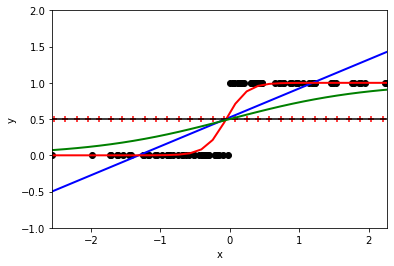

In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#definim la funció de la sigmoide
logistic = lambda s: 1.0 / (1.0 + np.exp(-s))

xmin, xmax = -10, 10
np.random.seed(0)
d = 0
X = np.random.normal(size = 100) + d
xmin, xmax = X.min(), X.max()

y = (X > d).astype(float) 
X = X[:, np.newaxis] 
X_pred = np.linspace(-4, 4, 50)

# Linear Regression:
rgr = linear_model.SGDRegressor( learning_rate='constant', eta0=0.01)
rgr.fit(X, y)
plt.plot(X_pred, rgr.coef_.ravel() * X_pred + rgr.intercept_, color = 'blue', linewidth = 2)

print(rgr.coef_, rgr.intercept_)

# Logistic Regression:
clf = linear_model.SGDClassifier(learning_rate='constant', eta0=0.05, max_iter=1000000)
clf.fit(X, y)
loss = logistic(X_pred * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_pred, loss, color = 'red', linewidth = 2)

print(clf.coef_, clf.intercept_)

plt.axhline(0.5, color = 'black')
plt.scatter(X, y, color = 'black')
plt.scatter(X_pred, X_pred*0+0.5, color = 'red', marker='+')

loss_nofit = logistic(X_pred).ravel()
plt.plot(X_pred, loss_nofit, color = 'green', linewidth = 2)


plt.ylabel('y')
plt.xlabel('x')

plt.ylim(-1, 2)
plt.xlim(xmin, xmax)

### Dataset per treballar aquesta pràctica:

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from sklearn.model_selection import GridSearchCV

sns.set_theme()


# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('winequalityN.csv')
dataset = dataset.dropna()
dataset['is_red_wine'] = (dataset["type"] == 'red').astype(int)


print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (6463, 14)


In [3]:
display(dataset)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red_wine
0,white,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,0
1,white,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,0
2,white,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,0
3,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
4,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.800,0.620,0.080,1.900,0.068,28.000,38.000,0.997,3.420,0.820,9.500,6,1
6492,red,6.200,0.600,0.080,2.000,0.090,32.000,44.000,0.995,3.450,0.580,10.500,5,1
6494,red,6.300,0.510,0.130,2.300,0.076,29.000,40.000,0.996,3.420,0.750,11.000,6,1
6495,red,5.900,0.645,0.120,2.000,0.075,32.000,44.000,0.995,3.570,0.710,10.200,5,1


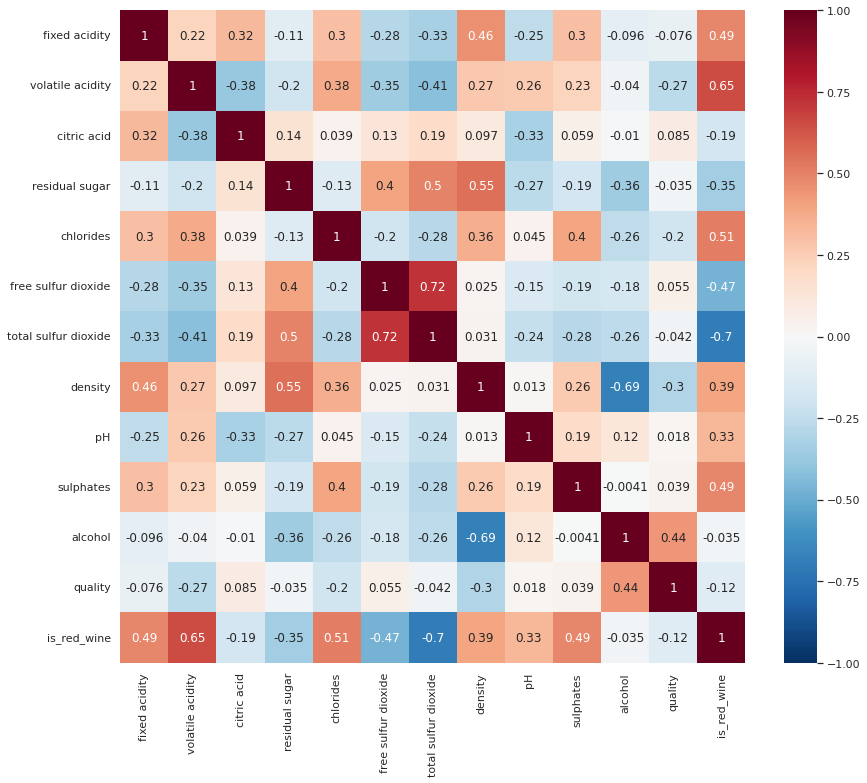

In [4]:
correlation = dataset.corr()
#display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

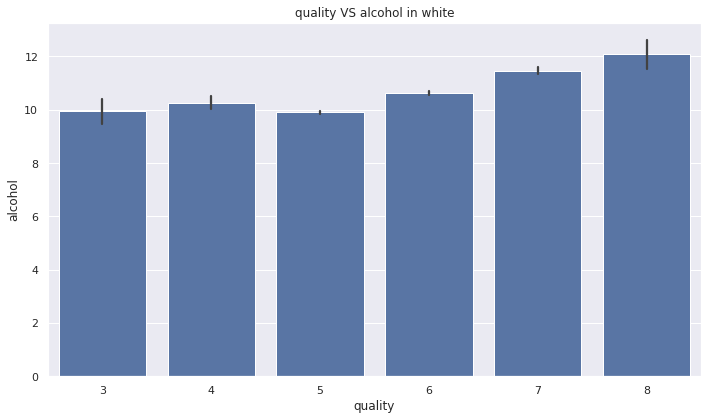

<Figure size 432x288 with 0 Axes>

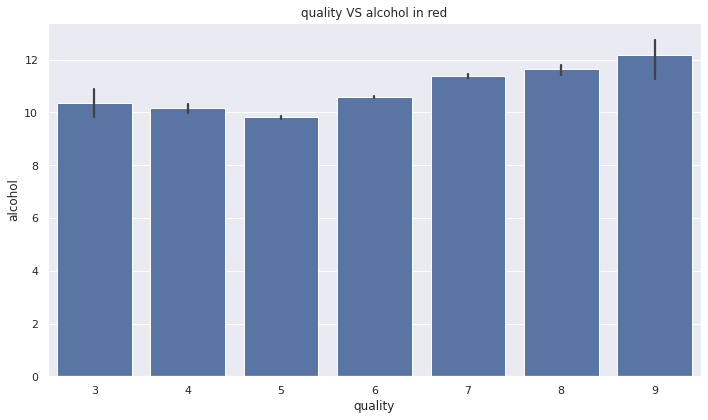

<Figure size 432x288 with 0 Axes>

In [5]:
fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="red"], ax=axs)
plt.title('quality VS alcohol in white')

plt.tight_layout()
plt.show()
plt.gcf().clear()

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="white"], ax=axs)
plt.title('quality VS alcohol in red')

plt.tight_layout()
plt.show()
plt.gcf().clear()

Abans de començar amb els exercicis, preparem les dades per a que sigui una **classificació binaria**

In [6]:
from pandas import read_csv
#Defining the splits for categories. 1-5 will be poor quality, 6-10 will be great
bins = [1,5,10]

#0 for low quality, 1 for great quality
quality_labels=[0,1]
dataset['quality_categorical'] = pd.cut(dataset['quality'], bins=bins, labels=quality_labels, include_lowest=True)
# Split the data into features and target label
quality_raw = dataset['quality_categorical']
features_raw = dataset.drop(['type', 'quality', 'quality_categorical'], axis = 1)


dataframe = read_csv("pima-indians-diabetes.csv", header=0, names=["Pregnancies", "Glucose", "Blood Preassure", "SkinThickness","Insulin", "BMI", "DiabetesPedigreeFunction","Age", "class"])
# get the values
values = dataframe.values
X_pima, y_pima = values[:, :-1], values[:, -1]



In [7]:
from sklearn.preprocessing import StandardScaler

# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, quality_raw, test_size = 0.2, random_state = 0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)
# Show the results of the split
print("Training set has {} samples. {:.1f}% is positive".format(X_train.shape[0], 100*sum(y_train)/y_train.shape[0]))
print("Testing set has {} samples. {:.1f}% is positive".format(X_test.shape[0], 100*sum(y_test)/y_test.shape[0]))

display(X_test)
display(y_test)


Training set has 5170 samples. 63.1% is positive
Testing set has 1293 samples. 64.3% is positive


array([[ 0.06004198, -0.54172432, -0.41586299, ..., -1.07443475,
        -1.07834864, -0.56707552],
       [-1.17544878, -0.78709703,  0.34376084, ...,  0.59933125,
         0.09516402, -0.56707552],
       [ 0.13726016,  0.13305062,  0.06753399, ..., -1.34223731,
         0.59809801, -0.56707552],
       ...,
       [-0.63492157,  1.42125733, -2.07322407, ...,  1.00103509,
        -0.82688164,  1.76343356],
       [-0.01717619, -0.97112656, -0.07057943, ..., -0.87358283,
         0.26280868, -0.56707552],
       [-0.94379426,  0.4397665 , -0.76114655, ..., -0.07017515,
         0.01134169, -0.56707552]])

3859    0
4675    1
513     1
5490    0
4329    0
       ..
410     1
4562    1
5626    0
1248    1
985     1
Name: quality_categorical, Length: 1293, dtype: category
Categories (2, int64): [0 < 1]

## Logistic Regression 

En aquesta secció us demanem que apliqueu de sklearn el model de [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

<font color=blue> Ompliu la funció *entrena_prediu_evalua*, amb la que s'entrena el model del paràmetre *learner* i es guarden els resultats de accuracy, precision, recall i F1-score.</font>

In [8]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

def entrena_prediu_evalua(learner,  X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: quality training set
       - X_test: features testing set
       - y_test: quality testing set
    '''
    
    results = {}
    
    """
    Fit/train the learner to the training data using slicing with 'sample_size' 
    """
    start = time()
    learner.fit(X_train, y_train)
    end = time() 
    
    results['train_time'] = end - start
    
    start = time()
    predictions_train = learner.predict(X_train)
    predictions_test = learner.predict(X_test)
    end = time() 
    
    results['pred_time'] = end - start
    results["train_accuracy"] = accuracy_score(y_train, predictions_train)
    results["test_accuracy"] = ???
    
    results["train_precision"] = ???
    results["test_precision"] = ???
    
    results["train_recall"] = ???
    results["test_recall"] = ???
    
    results["train_F1_score"] = ???
    results["test_F1_score"] = ???
          
    return results


SyntaxError: invalid syntax (1320121180.py, line 41)

### Què fa el parametre *C*  (a teroria inversa de $\lambda$).

El paràmetre *C* determina la potència de l'efecte que té el regularitzador sobre l'entrenament. En concret, quan usem un regularitzador $R(\theta)$, a la funció de pèrdua $J(\theta)$ se li suma $\frac{1}{C}R(\theta)$. És a dir, quant més alt el valor de *C* menys efecte tindrá el regularitzador (menys generarà biaix i reduirà la variància) i quant més baix el seu valor més efecte tindrà el regularitzador (mes generarà biaix i reduirà la variància).

**Quin és l'efecte del parametre C a les solucions que proporciona la regresió logisitica?**

<font color=blue> Utilitzant la funció *entrena_prediu_evalua*, genera models de *LogisticRegression* amb diferents valors de *C* i grafica els resultats de les mètriques de rendiment.</font>

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]

accuracies, precisions, recalls, f1_scores = [], [], [], []
accuracies_tr, precisions_tr, recalls_tr, f1_scores_tr = [], [], [], []

X_train, X_test, y_train, y_test = train_test_split(X_pima, y_pima, test_size = 0.3, random_state = 0)
for C in C_values:
    lr = LogisticRegression(C=???, solver=???, max_iter=???, penalty=???)
    results = ???
    accuracies.append(results['test_accuracy'])
    precisions.append(results['test_precision'])
    recalls.append(results['test_recall'])
    f1_scores.append(results['test_F1_score'])
    accuracies_tr.append(results['train_accuracy'])
    precisions_tr.append(results['train_precision'])
    recalls_tr.append(results['train_recall'])
    f1_scores_tr.append(results['train_F1_score'])

plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, label='Accuracy', marker='o')
plt.plot(C_values, precisions, label='Precision', marker='o')
plt.plot(C_values, recalls, label='Recall', marker='o')
plt.plot(C_values, f1_scores, label='F1-Score', marker='o')
plt.ylim([0,1])

plt.xscale('log')
plt.xlabel('Valor de C (log-scale)')
plt.ylabel('Métrica')
plt.title('Efecto del valor de C en las métricas del modelo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies_tr, label='Accuracy train', marker='o')
plt.plot(C_values, accuracies, '--', label='Accuracy test', marker='o')
# plt.ylim([0,1])
#plt.plot(C_values, precisions_tr, '--', label='Precision', marker='o')
#plt.plot(C_values, recalls_tr, '--', label='Recall', marker='o')
#plt.plot(C_values, f1_scores_tr, '--', label='F1-Score', marker='o')

plt.xscale('log')
plt.xlabel('Valor de C (log-scale)')
plt.ylabel('Métrica')
plt.title('Efecto del valor de C en las métricas del modelo')
plt.legend()
plt.grid(True)
plt.show()

Observem que les métriques creixen amb *C*, i s'estaquen a partir de $C=10$. Això pasa perque, per a valors baixos de $C$ el biaix creix massa i impedeix que el model lineal modelitzi bé la distribució de dades. 

**Pensa que no se pot utilitzar l1 amb els algorismes que impliquen derivades, degut a que el p l1 no és continua i per tant no és derivable**

Què passa si fem servir poques dades per entrenar? (mostra com varien els resultats segons % de entrenament)?

<font color=blue> Utilitzant la funció *entrena_prediu_evalua*, genera models de *LogisticRegression* amb diferents quantitat de dades d'entrenament i grafica els resultats de les mètriques de rendiment.</font>


In [ ]:
train_sizes = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
accuracies, precisions, recalls, f1_scores = [], [], [], []
lr = ???
for size in train_sizes:
    results = ???
    display(lr.coef_)
    accuracies.append(???)
    precisions.append(???)
    recalls.append(???)
    f1_scores.append(???)

    
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracies, marker='o', label='Accuracy', color='blue')
#plt.plot(train_sizes, precisions, marker='o', label='Precision', color='green')
#plt.plot(train_sizes, recalls, marker='o', label='Recall', color='orange')
#plt.plot(train_sizes, f1_scores, marker='o', label='F1 Score', color='red')

plt.title("Rendiment segons la quantitat de dades d'entrenament")
plt.xlabel("Mida del conjunt d'entrenament (%)")
plt.ylabel('Mètriques')
plt.xticks(train_sizes, [f"{int(size * 100)}%" for size in train_sizes])
plt.legend()
plt.grid()
plt.show()



### GridSearchCV

*GridSearchCV* és una eina d'optimització d'hiperparàmetres per a models d'aprenentatge automàtic. Consisteix a fer una cerca exhaustiva de combinacions d'hiperparàmetres possibles per a un model, amb l'objectiu de trobar la configuració que ofereixi el millor rendiment.

En comptes d'ajustar manualment els hiperparàmetres del model, *GridSearchCV* automatitza aquest procés provant totes les combinacions dels valors definits per l'usuari. Aquest enfocament utilitza validació creuada per avaluar el rendiment de cada combinació, garantint que la selecció final d'hiperparàmetres estigui optimitzada i no depengui d'un conjunt de dades d'entrenament o prova únic.

In [ ]:
parameters = {'max_iter':[500, 1000, 5000], 'C':[0.01,0.1, 1, 10,100],'penalty':['l2','l1','elasticnet'],'solver':["saga", "liblinear"]}
lr = LogisticRegression()
clf_ = GridSearchCV(lr, parameters, n_jobs=14)
clf_.fit(X_train,y_train)

In [ ]:
clf_.score(X_test,y_test),clf_.score(X_train,y_train)

In [ ]:
clf_.best_score_

In [ ]:
print(clf_.best_params_)
print(clf_.__dict__.keys())


Els paràmetres obtinguts després d'aplicar GridSearchCV corresponen als millors valors trobats per al vostre model de regressió logística en base a les dades d'entrenament.

* C = 10: Aquest paràmetre controla la regularització del model. És l'invers de la força de regularització, de manera que valors més alts de C impliquen menys regularització. En aquest cas, amb C = 10, el model té poca regularització, permetent més flexibilitat, cosa que pot ser útil si les dades tenen patrons complexos.

* solver = 'liblinear': El solver és l'algorisme utilitzat per optimitzar el model. liblinear és adequat per a conjunts de dades petites i admet la regularització l1.

* penalty = 'l1': És el tipus de regularització aplicada. La penalització l1 (també coneguda com a Lasso) força que alguns coeficients del model es tornin exactament zero, cosa que efectivament realitza una selecció de variables.

* max_iter = 500: És el nombre màxim d'iteracions que l'algorisme d'optimització (en aquest cas, liblinear) permet intentar ajustar el model. Un valor de 500 indica que l'algorisme pot fer fins a 500 iteracions abans d'aturar-se.

## Multi-class classification
La regressió logística multiclasse és una extensió de la regressió logística tradicional, dissenyada per resoldre problemes en què la variable dependent o de sortida té més de dues categories possibles.


### One-Vs-Rest 

One-vs-rest (OvR  or One-vs-All/OvA) és un mètode heurístic per utilitzar algorismes de classificació binària per a la classificació multiclasse.

Es tracta de dividir el conjunt de dades multiclasse en múltiples problemes de classificació binària. Un classificador binari és llavors entrenat en cada problema de classificació binària i les prediccions es fan utilitzant el model amb una probabilitat més alta (arg max pel tipus de classe que és).

$$
argmax\{y_1, y_2, \cdots y_n\} | n \in \mathbb{R}
$$

### One-Vs-One

OVO divideix un conjunt de dades de classificació multiclasse en problemes de classificació binaris. A diferència de OVR que el divideix en un conjunt de dades binari per a cada classe, l'enfocament del OVO és dividir el conjunt de dades respecte a un problema de classificació binaria de tots contra tots. Per tant tenim 
$$
\frac{n * (n-1 )}{2}
$$
on n $=$ nombre de classes

Per exemple, considereu un problema de classificació multiclasse amb quatre classes: $vermell, blau, verd$ i $groc$. Això es podria dividir en sis conjunts de dades de classificació binaria:

    Binary Classification Problem 1: red vs. blue
    Binary Classification Problem 2: red vs. green
    Binary Classification Problem 3: red vs. yellow
    Binary Classification Problem 4: blue vs. green
    Binary Classification Problem 5: blue vs. yellow
    Binary Classification Problem 6: green vs. yellow
    
Tenint així 6 classificadors la sortida del final del model és 
$$
max\{{\sum_{i=1}^6 argmax[Model_i = C]}\}
$$

## Exemples amb dades sintètiques

In [ ]:
### OVR
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression()
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)

yhat = ovr.predict(X[:5])
print(yhat)


In [ ]:
### OVO
# define model
model = LogisticRegression()
ovr = OneVsOneClassifier(model)
# fit model
ovr.fit(X, y)

yhat = ovr.predict(X[:5])
print(yhat)


In [ ]:
# Generar dades sintètiques
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=4, random_state=1)

model = LogisticRegression()
ovr = OneVsRestClassifier(model)

ovr.fit(X, y)

print("=== Clasificadores internos OVR ===")
for i, est in enumerate(ovr.estimators_):
    print(f"Clasificador {i+1} (clase {i} vs resto): {est}")

print("\n=== Predicciones de cada clasificador (para las primeras 10 muestras) ===")
l = [est.predict(X[:10]) for est in ovr.estimators_]
predicciones_internas = np.array(l).transpose()
display(predicciones_internas)

# Agregación de las probabilidades de los clasificadores
print("\n=== Agregación de las probabilidades de los clasificadores ===")
yhat_prob = ovr.predict_proba(X[:10])
display(yhat_prob)

# Predicción final agregada
print("\n=== Clasificación final (predicciones agregadas) ===")
yhat_final = ovr.predict(X[:10])
display(np.array(yhat_final).transpose())

*En aquest cas la sortida del classificador del OVR ve a partir d'un procés. Primerament veiem que tot i que és una classificació multinomial el OVR ha generat 4 Logistics per a fer la predicció. Tot i que estem en un problema de classificació multinomial cada estimador és binari (1 classe vs les altres (1, 0)) per això hi han 1 i 0.*


*La següent passa és agregar la probabilitat de les classes de cada un dels estimadors que té els seus propis predict_proba i després de l'agregació finalment se queda amb el estimador amb la màxima prob agregada*

In [ ]:
# Definir modelo base y el esquema OneVsOne
model = LogisticRegression()
ovo = OneVsOneClassifier(model)

# Entrenar el clasificador
ovo.fit(X, y)

# Mostrar los clasificadores internos OVO
print("=== Clasificadores internos OVO ===")
for i, est in enumerate(ovo.estimators_):
    print(f"Clasificador {i+1}: {est}")
    
# Predicciones de los clasificadores internos para las primeras 5 muestras
print("\n=== Predicciones de cada clasificador (para las primeras 10 muestras) ===")
l = [est.predict(X[:10]) for est in ovo.estimators_]
predicciones_internas = np.array(l).transpose()
display(predicciones_internas)

# Agregación de las probabilidades de los clasificadores
print("\n=== Agregación de las probabilidades de los clasificadores ===")
yhat_decision = ovo.decision_function(X[:10])
display(yhat_decision)

# Predicción final agregada
print("\n=== Clasificación final (predicciones agregadas) ===")
yhat_final = ovo.predict(X[:10])
display(np.array(yhat_final).transpose())



*En aquest cas la sortida del classificador del OVO és diferent. Veiem en aquesta estratègia s'han generat 6 logístiques per a fer la predicció (la permutació binaria de totes amb totes com s'ha vist en s'explicació de dalt. Cada Logistic fa la predicció binaria respecte a les dues classes que està comparant.*


*La següent passa és agregar el nombre de "prediccions" que ha tingut cada classe en els seus estimadors corresponents i segons una  normalització per evitar que hi hagi "empats". Finalment el model es queda amb la classe que ha tingut "major" nombre de vots (en aquest cas normalitzat)*

### D'aquí podeu veure que el el OVO és una bona estratègia quan tens unes dades molt balancejades i sobre tot va molt be quan en tens moltes, donat que estas entrenant models molt més petits.

### Per l'altra banda en cas del OVR va be quan tens casos una mica més desbalancejats per a nivellar el aprenentatge de les classes.

In [ ]:
best_model = LogisticRegression(**clf_.best_params_)
ovo = OneVsOneClassifier(best_model)
ovr = OneVsRestClassifier(best_model)

#Entrenament de les dues estratègies
ovo.fit(X_train, y_train)
ovr.fit(X_train, y_train)

ovo_pred = ovo.predict(X_test)
ovr_pred = ovr.predict(X_test)

ovo_accuracy = accuracy_score(y_test, ovo_pred)
ovr_accuracy = accuracy_score(y_test, ovr_pred)

print(f'Accuracy One-vs-One: {ovo_accuracy}')
print(f'Accuracy One-vs-Rest: {ovr_accuracy}')


## Exemple amb un dataset

In [ ]:
df = read_csv('fish_data.csv')
df.head()

In [ ]:
X = df.drop('species', axis = 1)
y = df['species']

In [ ]:
X.head()

In [ ]:
print(y.unique())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 

<font color=blue> Primer de tot, hem de transformar les dades </font>

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = ???

scaler.fit(???)

X_train_scaled = scaler.transform(???)
X_test_scaled = ???

###

<font color=blue> Quina estratègia funciona millor amb el dataset? Fes la comparació entre One vs Rest (OvR) i One vs One (OvO) </font>

In [ ]:
### Logistic regression ###

# Logistic Regression with OvR 
model = LogisticRegression()
ovr_model = ???
ovr_model.fit(???, ???)

# Logistic Regression with OvO
ovo = ???
ovo.fit(???, ???)

# Predictions for OvR model
ovr_predict = ovr_model.predict(???)
# Calculate accuracy for OvR
ovr_accuracy = accuracy_score(???, ???)
print(f"Accuracy for Logistic Regression with OvR: {ovr_accuracy:.2f}")

# Predictions for OvO model
ovo_predict = ovo.predict(???)
# Calculate accuracy for OvO
ovo_accuracy = accuracy_score(???, ???)
print(f"Accuracy for Logistic Regression with OvO: {ovo_accuracy:.2f}")

###  

**També es poden utilitzar les estratègies OvO i OvR amb un classificador *KNN*.**

<font color=blue> Quina estratègia funciona millor amb el dataset? Fes la comparació entre One vs Rest (OvR) i One vs One (OvO) utilitzant un *KNN* com a classificador </font>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### KNN ###

# KNN with OvR
model = KNeighborsClassifier(n_neighbors = 29)
knn_ovr = ???
knn_ovr.fit(???, ???)

# KNN with OvO
knn_ovo = ???
knn_ovo.fit(???, ???)

# Predictions for OvR model
knn_ovr_predict = ovr_model.predict(???)
# Calculate accuracy for OvR
knn_ovr_accuracy = ???
print(f"Accuracy for KNN with OvR: {knn_ovr_accuracy:.2f}")

# Predictions for OvO model
knn_ovo_predict = ???
# Calculate accuracy for OvO
knn_ovo_accuracy = ???
print(f"Accuracy for KNN with OvO: {knn_ovo_accuracy:.2f}")

###  

**Comparació utilitzant les mètriques**

In [ ]:
def get_metrics(model, X_test, y_test):
    # Get predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy, precision, recall, f1 score
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
# Create the empty list for storing metrics for each model
data = []

# Logistic Regression OvR
log_ovr_accuracy, log_ovr_precision, log_ovr_recall, log_ovr_f1 = get_metrics(ovr_model, X_test_scaled, y_test)
data.append({'model': 'Logistic Regression', 'strategy': 'OvR', 'accuracy': log_ovr_accuracy, 'precision': log_ovr_precision, 'recall': log_ovr_recall, 'f1': log_ovr_f1})

# Logistic Regression OvO
log_ovo_accuracy, log_ovo_precision, log_ovo_recall, log_ovo_f1 = get_metrics(ovo, X_test_scaled, y_test)
data.append({'model': 'Logistic Regression', 'strategy': 'OvO', 'accuracy': log_ovo_accuracy, 'precision': log_ovo_precision, 'recall': log_ovo_recall, 'f1': log_ovo_f1})

# KNN OvR
knn_ovr_accuracy, knn_ovr_precision, knn_ovr_recall, knn_ovr_f1 = get_metrics(knn_ovr, X_test_scaled, y_test)
data.append({'model': 'KNN', 'strategy': 'OvR', 'accuracy': knn_ovr_accuracy, 'precision': knn_ovr_precision, 'recall': knn_ovr_recall, 'f1': knn_ovr_f1})

# KNN OvO
knn_ovo_accuracy, knn_ovo_precision, knn_ovo_recall, knn_ovo_f1 = get_metrics(knn_ovo, X_test_scaled, y_test)
data.append({'model': 'KNN', 'strategy': 'OvO', 'accuracy': knn_ovo_accuracy, 'precision': knn_ovo_precision, 'recall': knn_ovo_recall, 'f1': knn_ovo_f1})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)
df = round(df, 2)
df = df.sort_values(by=['accuracy', 'precision', 'recall', 'f1'], ascending=False)

# Display the DataFrame as a table
print(df)